# Analysis deep layer optogenetics 1

In [1]:
# the following two lines indicate that external functions are auto-reloaded as soon as they change. 
%load_ext autoreload
%autoreload 2
# Print statements 
from __future__ import print_function # Python 2.x

In [2]:
# General stuff:
import sys
import argparse
import os
import json
import numpy as np
import math
import psycopg2
import cPickle
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm_notebook

# Plotting:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib as mpl
%matplotlib inline
from IPython.display import display, HTML

# External functions from subfolder /database_helpers. 
# as soon as you change something in there and press save, it will auto reload on next execution.
from database_helpers.psql_start import *
from database_helpers.create_tables import *
from database_helpers.write2tables import *

# register pickle type to retrieve binary data from database
psycopg2.extensions.register_type(psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BINARY-PICKLE', cast_pickle))

Loaded analysis helpers: General


In [21]:
def plot_comparisons(scores_df,score,ylabel,separator,figure_size):
    figure = plt.figure(figsize=figure_size)
    sns.set(font_scale=1.)
    sns.set_style('white')

    ax1 = figure.add_subplot(2,1,1)
    # Draw a nested boxplot to show bills by day and sex
    ax1.axhline(y=0,zorder=0,color='k')
    sns.violinplot(x=separator, y=score, hue='excited',data=scores_df, palette="Greys",split=True,
                bw=.3,axes=ax1)
    sns.stripplot(x=separator, y=score, hue='excited',data=scores_df, palette="Reds",split=True,
                axes=ax1,jitter=.1,alpha=.5)
    ax1.set_title('{}'.format(ylabel),y=1.05)
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel('')

    handles, labels = ax1.get_legend_handles_labels()
    l = plt.legend(handles[2:4], labels[2:4],loc=1, borderaxespad=0.)

    # do the same for inhibited cells
    ax2 = figure.add_subplot(2,1,2)
    # Draw a nested boxplot to show bills by day and sex
    ax2.axhline(y=0,zorder=0,color='k')
    sns.violinplot(x=separator, y=score, hue='inhibited',data=scores_df, palette="Greys",split=True,
                bw=.3,axes=ax2)
    sns.stripplot(x=separator, y=score, hue='inhibited',data=scores_df, palette="Blues",split=True,
                axes=ax2,jitter=.1,alpha=.5)
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel('')

    handles, labels = ax2.get_legend_handles_labels()
    l = plt.legend(handles[2:4], labels[2:4], loc=1, borderaxespad=0.)
    sns.despine(offset=0, trim=True)    
    plt.show()

In [3]:
db_status = test_connect()
if db_status == False:
    print('Grrr... no database connection could be established.')
else:
    print('Yippiyeah! Database connection is established!')

Connecting to the PostgreSQL database...
Yippiyeah! Database connection is established!


In [4]:
# load the parameters to connect to data_1 
params = config()

## Analysis

Retrieve stimulus table for deep layer mice (**retro-cre**, **DIOCheta injections**)

In [5]:
# retrieve complete chunk from BNT_scores_tb
# exclude laser and object sessions!

sql = "SELECT * \
      FROM BNT_scores_tb \
      WHERE (animal_id = '70258' OR \
      animal_id = '70644' OR animal_id = '70645' OR animal_id = '71343' \
      OR animal_id = '71379' OR animal_id = '71461' OR animal_id = '71462' \
      OR animal_id = '72254' OR animal_id = '72255' OR animal_id ='72878' \
      OR animal_id = '71710' OR animal_id = '72257' OR animal_id= '72877') \
      AND session_name NOT LIKE '%las%' AND session_name NOT LIKE '%obj%' \
      ORDER BY session_ts ASC;".format()
BNT_scores = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None,parse_dates=['session_ts','analysis_ts'])
#BNT_scores = BNT_scores.groupby(['animal_id','session_ts','tetrode_no','cluster_no']).mean().reset_index()
print('{} entries found in database for BNT scores'.format(len(BNT_scores)))

2055 entries found in database for BNT scores


In [6]:
# loop over data and find corresponding entry in stimulus.mat

In [7]:
salt_i_thresh = .1
salt_p_thresh = .05
inhib_p_thresh = .001 # arbitrary at the moment!

In [8]:
# create dataframe(s)
# filter on cluster_no, tetrode_no, session_name, n_drive_user, animal_id, session_ts
BNT_scores['inhibited'] = np.zeros((len(BNT_scores)))
BNT_scores['excited'] = np.zeros((len(BNT_scores)))
BNT_scores['session_count_exc'] = np.zeros((len(BNT_scores))) # for counting how many subsessions met criterion
BNT_scores['session_count_inhib'] = np.zeros((len(BNT_scores))) # for counting how many subsessions met criterion

In [16]:
skipped = 0 
skipped_rm = 0

for i in tqdm_notebook(xrange(len(BNT_scores))):
    c_entry = BNT_scores.iloc[i]
    if np.isnan(float(c_entry.animal_id)): print('skipping.');skipped+=1;continue
    sql = "SELECT * \
      FROM stimulus_tb \
      WHERE animal_id = '{}' AND cluster_no = {} AND tetrode_no = {} AND \
      session_ts = '{}';".format(c_entry.animal_id,c_entry.cluster_no,c_entry.tetrode_no,
                                                    c_entry.session_ts)
    c_sql = pd.read_sql_query(sql, psycopg2.connect(**params), index_col=None,parse_dates=['session_ts','analysis_ts'])
    if len(c_sql) == 0:
        #print('no entry found for: {},{},{},{}'.format(c_entry.animal_id,c_entry.session_ts,c_entry.cluster_no,c_entry.tetrode_no))
        skipped+=1
        continue # because that clearly suggests that there is no stimulus stuff to analyze ;)
        
    if len(c_sql) >= 1:
        if (c_sql.salt_p<salt_p_thresh).any() & (c_sql.salt_i>salt_i_thresh).any():
            BNT_scores.set_value(i,'excited',1) 
            BNT_scores.set_value(i,'session_count_exc',
                                 len(c_sql[(c_sql.salt_p<salt_p_thresh) & (c_sql.salt_i>salt_i_thresh)]))
        if (c_sql.inhib_lowest_p<inhib_p_thresh).any() & (c_sql.inhibited == True).any():
            BNT_scores.set_value(i,'inhibited',1) 
            BNT_scores.set_value(i,'session_count_inhib',
                                 len(c_sql[c_sql.inhib_lowest_p<inhib_p_thresh]))        

In [17]:
# map True False
label = {1: True, 0: False}
BNT_scores['inhibited']= BNT_scores['inhibited'].map(label)
BNT_scores['excited']= BNT_scores['excited'].map(label)
BNT_scores['all_cells'] = np.zeros((len(BNT_scores))) # generic column if you want to plot seaborn summary over all animals 
label = {0: 'All cells'}
BNT_scores['all_cells']= BNT_scores['all_cells'].map(label)

### Plot comparisons

In [22]:
# what to plot
comparisons_dict = {'gridscore':'Grid score','borderscore':'Border score','mvl':'Mean Vector Length (MVL)',
                   'informationcontent':'Information Content','informationrate':'Information rate'}

Generating figure for: Information Content


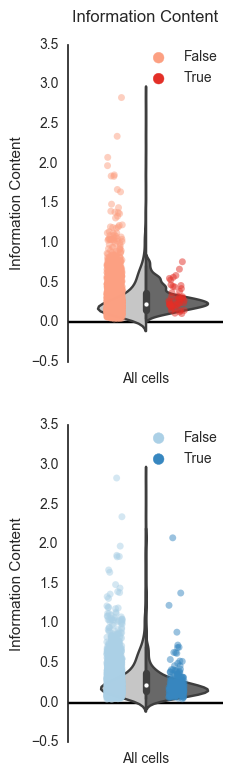

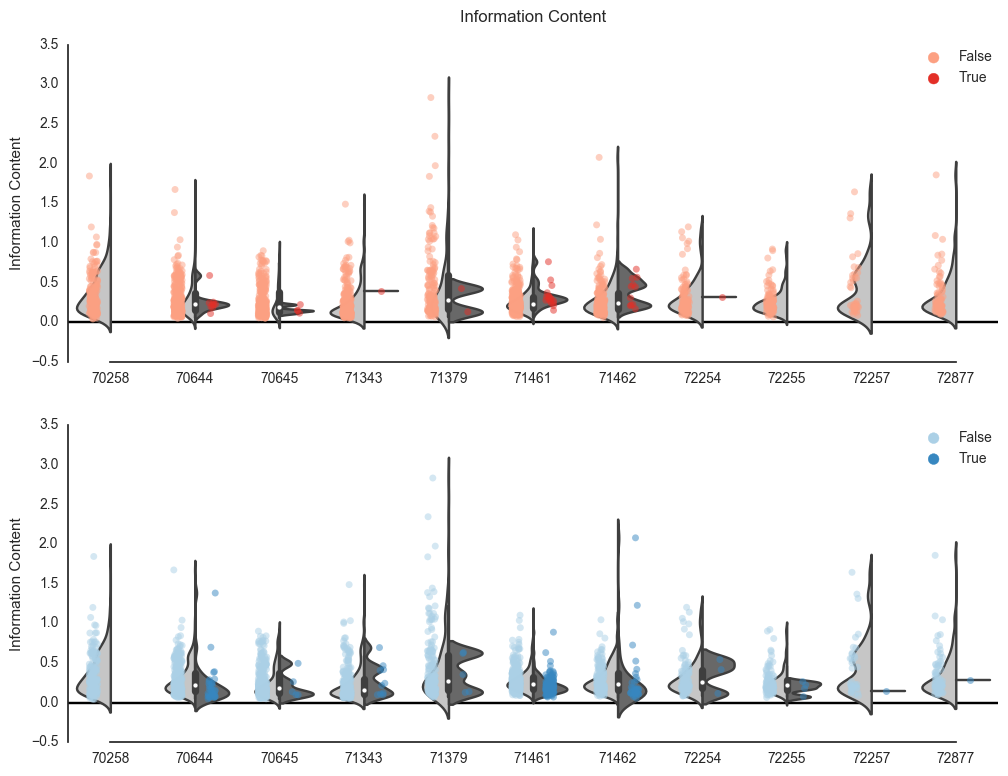

Generating figure for: Information rate


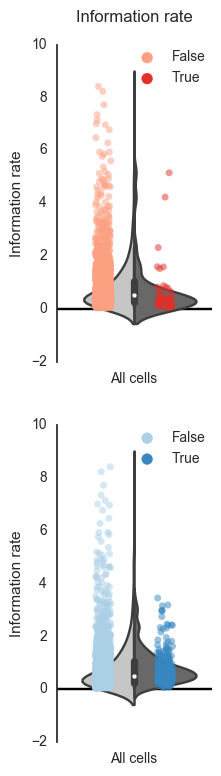

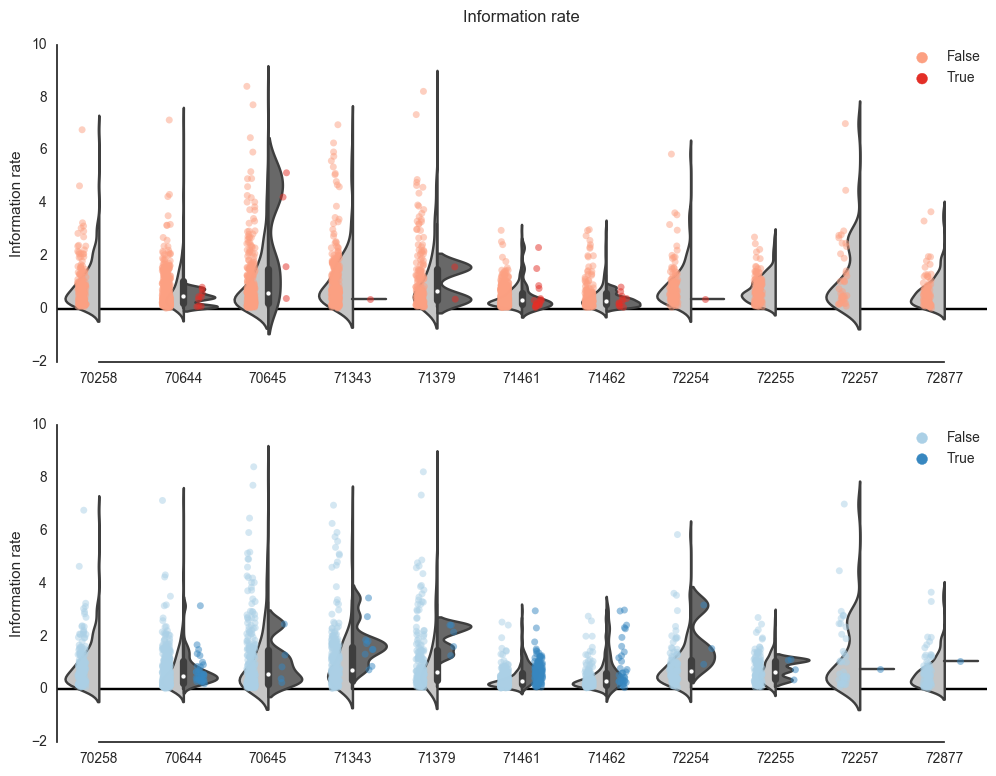

Generating figure for: Border score


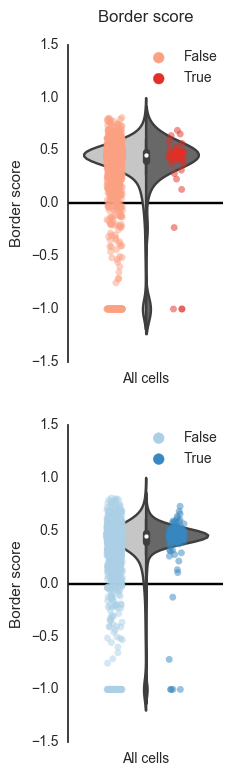

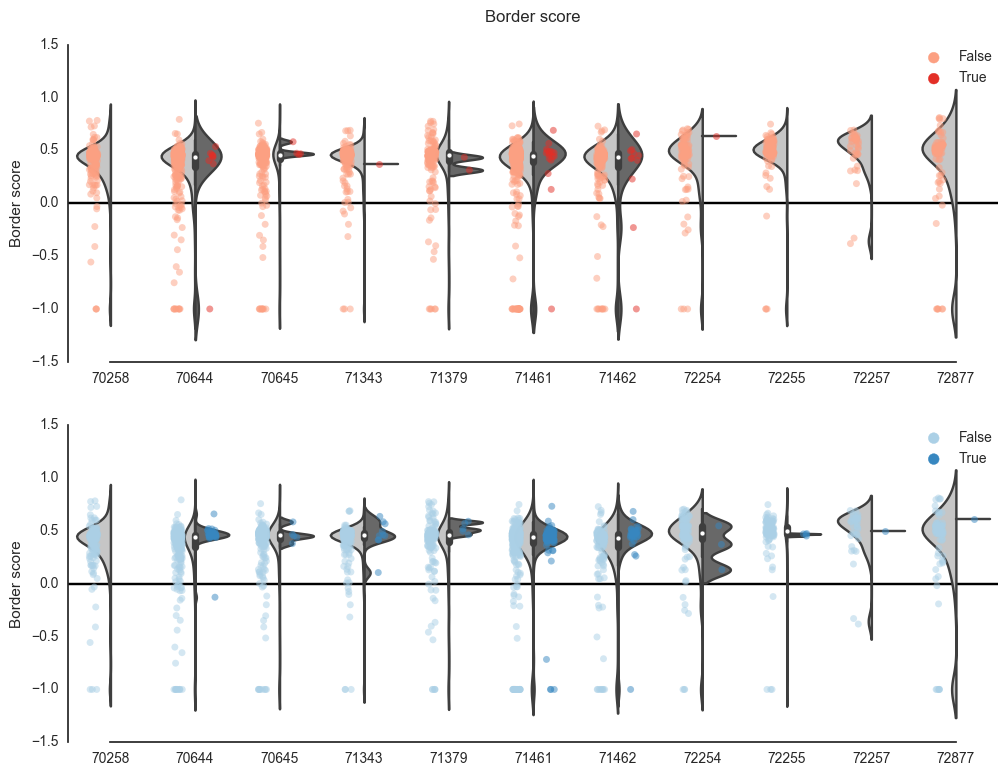

Generating figure for: Mean Vector Length (MVL)


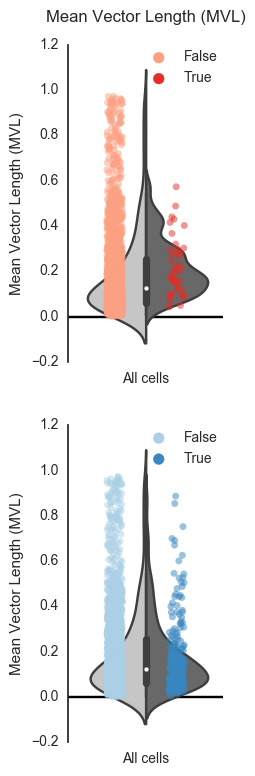

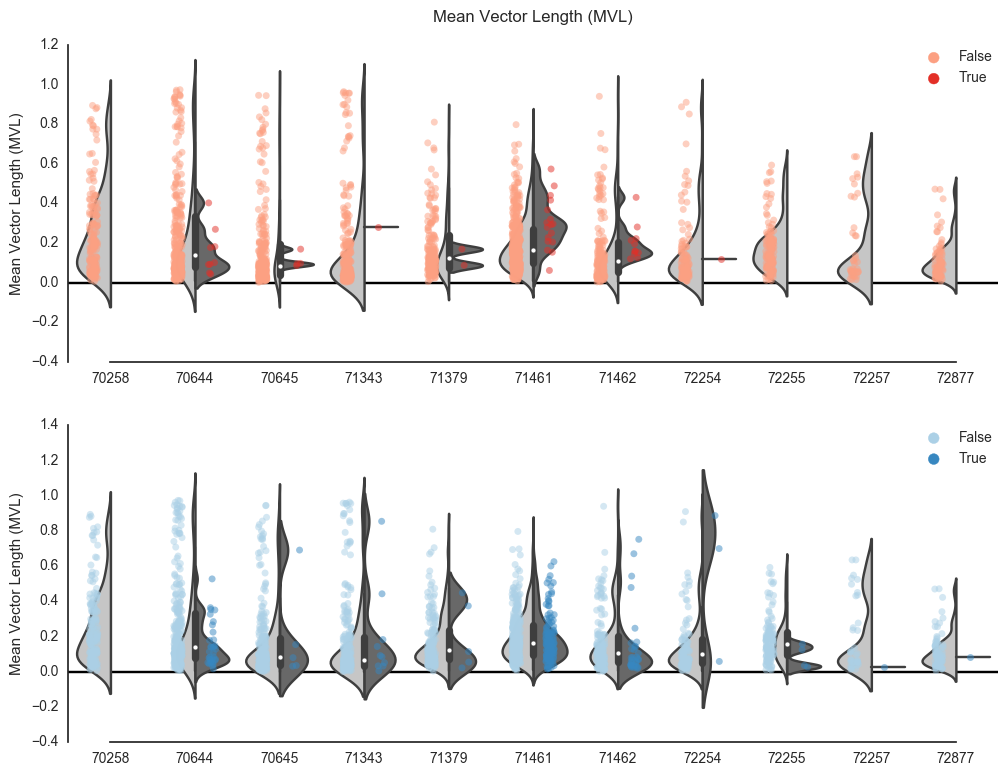

Generating figure for: Grid score


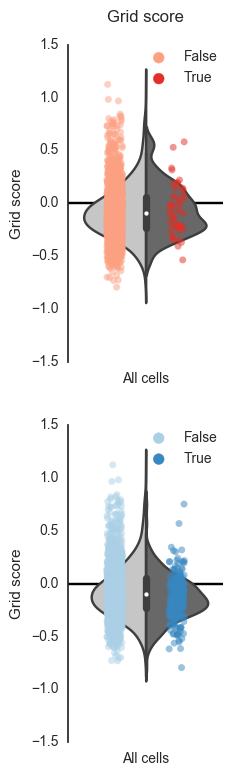

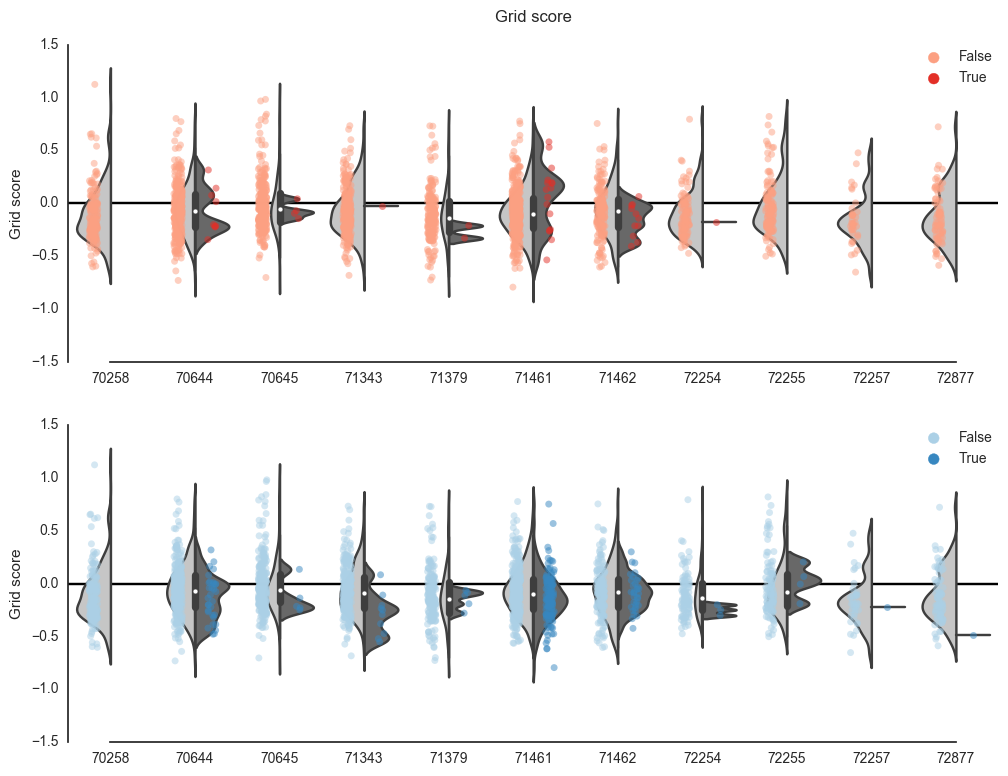

In [23]:
# generate plots
for i in comparisons_dict:
    print('Generating figure for: {}'.format(comparisons_dict[i]))
    plot_comparisons(BNT_scores,i,comparisons_dict[i],'all_cells',(2,9))
    plot_comparisons(BNT_scores,i,comparisons_dict[i],'animal_id',(12,9))